# Crowdfunding Projects Clustering
#### Author: Kunyu He, CAPP'20, The University of Chicago

In [1]:
import sys
sys.path.append('../codes/')

In [2]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
 
from featureEngineering import FeaturePipeLine, create_dirs
from viz import read_data
from kmeans import KMeansPipeline

In [3]:
INPUT_DIR = "../data/"

## 1. Load Data

In [4]:
project = read_data("projects.csv", drop_na=False)
project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 27 columns):
projectid                                 124976 non-null object
teacher_acctid                            124976 non-null object
schoolid                                  124976 non-null object
school_ncesid                             115743 non-null float64
school_latitude                           124976 non-null float64
school_longitude                          124976 non-null float64
school_city                               124976 non-null object
school_state                              124976 non-null object
school_metro                              109752 non-null object
school_district                           124804 non-null object
school_county                             124976 non-null object
school_charter                            124976 non-null object
school_magnet                             124976 non-null object
teacher_prefix                           

## 2. Data Preprocessing

As we are dealing with a clustering task, there's no need to split the data set before preprocessing. First, adjust the configuration of preprocessing pipeline.

In [5]:
FeaturePipeLine.TO_CREATE_CON = {'days_fully_funded': (['datefullyfunded',
                                                        'date_posted'],
                                                       lambda x, y: (x - y + pd.Timedelta(days=1)).dt.days)}

Note that compared to the preprocessing pipeline for the classification task, I dropped `school_city`, `school_state`, `school_district`, and `school_county`.

Note that as I'm no longer predicting whether a project would fail to get fully funded in 60 days, leakage from incorporating both `date_posted` and `datefullyfunded` is no longer of concern. Thus, I further included the year and month of year information for `datefullyfunded` into the processed data. Also, I added a new feature `days_fully_funded` as the number of days the project took to get fully funded.

In [6]:
train_pipe = FeaturePipeLine("Full", project, ask_user=False, test=False)
train_pipe.con_fill_na().str_fill_na().con_create().extract_date().to_binary().feature_target_split()

#----------------------------------------------------------------------------------------------------------------------------------#
<BATCH Full> Creating the preprocessing pipeline for 'projects.csv'.
	Finished reading cleaned data.

<BATCH Full: Training data preprocessing> Pipeline using Standard Scaler.


Start to impute missing values continuous variables:
	Missing values in 'students_reached' imputed with column  median 30.000.


Start to fill in missing values:
	Filled missing values in 'grade_level' with 'Grades PreK-2'.
	Filled missing values in 'school_metro' with 'urban'.
	Filled missing values in 'school_district' with 'MISC'.
	Filled missing values in 'primary_focus_subject' with 'Other'.
	Filled missing values in 'primary_focus_area' with 'Other'.
	Filled missing values in 'secondary_focus_subject' with 'MISC'.
	Filled missing values in 'secondary_focus_area' with 'MISC'.
	Filled missing values in 'resource_type' with 'Technology'.


Start to create new continuous variabl

Preprocess the data and keep enough information to describe each cluster.

In [7]:
project = train_pipe.data.copy(deep=True)
project.head()

,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,school_county,school_charter,school_magnet,teacher_prefix,...,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,days_fully_funded
0,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,Cook,0.0,0.0,Mrs.,...,Math & Science,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,0.0,19
1,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,Ventura,0.0,0.0,Mrs.,...,History & Civics,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,1.0,12
2,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,Los Angeles,0.0,0.0,Ms.,...,Literacy & Language,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,0.0,77
3,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,Kings (Brooklyn),0.0,1.0,Ms.,...,Literacy & Language,MISC,MISC,Books,high poverty,Grades PreK-2,175.33,23.0,0.0,56
4,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,Suffolk,0.0,0.0,Mrs.,...,Literacy & Language,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,0.0,77


Create a KMeans pipeline and finish the preprocessing.

In [8]:
kmeans_pipe = KMeansPipeline(None, project.copy(deep=True), [5, 10, 50, 100, 200, 300, 500])

In [9]:
kmeans_pipe.preprocess("Full")

#----------------------------------------------------------------------------------------------------------------------------------#
<BATCH Full> Creating the preprocessing pipeline for 'projects.csv'.
	Finished reading cleaned data.

<BATCH Full: Training data preprocessing> Pipeline using Standard Scaler.


Start to combine unnecessary levels of multinomials.
	Combinations of levels on 'school_city'.
	Combinations of levels on 'school_state'.
	Combinations of levels on 'school_district'.
	Combinations of levels on 'school_county'.
	Combinations of levels on 'primary_focus_subject'.
	Combinations of levels on 'primary_focus_area'.
	Combinations of levels on 'secondary_focus_subject'.
	Combinations of levels on 'secondary_focus_area'.
	Combinations of levels on 'resource_type'.


Finished applying one-hot-encoding to the following categorical variables: ['school_city', 'school_state', 'school_district', 'school_county', 'school_metro', 'teacher_prefix', 'primary_focus_subject', 'primar

Up till now, data is ready for clustering.

## 3. Projects Clustering

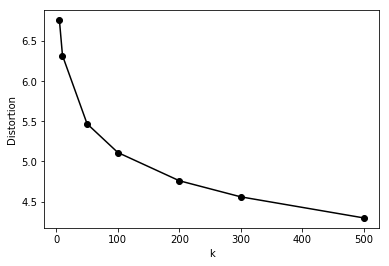

In [10]:
kmeans_pipe.find_best_k()

There's no obvious elbow but 50 seems to be a reasonable number of clusters. Apply it to the data set.

In [11]:
kmeans_pipe.apply_cluster(50)

#### 3.1 Describe Data Points in a Cluster

Print summary statistics of cluster 7.

In [12]:
kmeans_pipe.describe_cluster(7)

,school_latitude,school_longitude,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,days_fully_funded
count,3555.000000,3555.000000,3555.000000,3555.000000,3555.000000,3555.000000,3555.000000,3555.000000
mean,38.887026,-97.759886,0.074543,0.071449,546.472309,61.543741,0.239381,47.659072
std,4.630436,19.400751,0.262689,0.257609,382.383700,103.627398,0.426766,31.262979
min,19.387832,-164.540186,0.000000,0.000000,106.920000,1.000000,0.000000,6.000000
25%,35.910574,-117.317509,0.000000,0.000000,318.030000,24.000000,0.000000,23.000000
50%,38.921478,-90.195206,0.000000,0.000000,472.540000,30.000000,0.000000,40.000000
75%,41.825718,-81.484451,0.000000,0.000000,646.460000,60.000000,0.000000,69.000000
max,63.093271,-69.971245,1.000000,1.000000,6803.690000,999.000000,1.000000,121.000000


#### 3.2 Find Distinctive Features of a Cluster 

#----------------------------------------------------------------------------------------------------------------------------------#
<BATCH > Creating the preprocessing pipeline for 'projects.csv'.
	Finished reading cleaned data.

<BATCH : Training data preprocessing> Pipeline using Standard Scaler.


Start to combine unnecessary levels of multinomials.
	Combinations of levels on 'school_city'.
	Combinations of levels on 'school_state'.
	Combinations of levels on 'school_district'.
	Combinations of levels on 'school_county'.
	Combinations of levels on 'primary_focus_subject'.
	Combinations of levels on 'primary_focus_area'.
	Combinations of levels on 'secondary_focus_subject'.
	Combinations of levels on 'secondary_focus_area'.
	Combinations of levels on 'resource_type'.


Finished applying one-hot-encoding to the following categorical variables: ['school_city', 'school_state', 'school_district', 'school_county', 'school_metro', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_

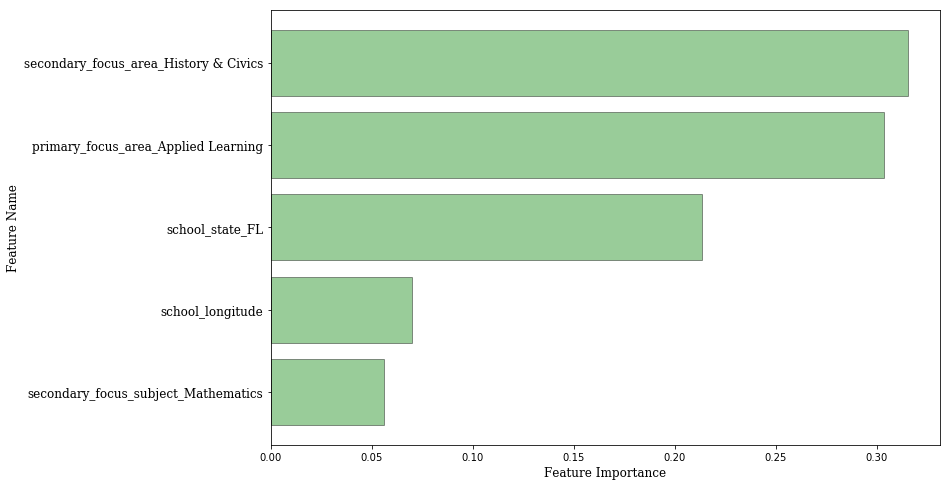

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [13]:
kmeans_pipe.find_distinctive_features(7, 5)

## 4. User Interaction

#### 1. Recluster

User can recluster with a new `k`, say, 75 with the `cluster(k)` method. It returns a KMeans fitted model.

In [ ]:
kmeans_75 = kmeans_pipe.cluster(75)
kmeans_75

#### 2. Merge several clusters into one

To split a specific cluster into many, the user need to apply one KMeans model to the data. Say KMeans model with 50 clusters.

In [ ]:
kmeans_pipe.apply_cluster(50)

The `merge_clusters(to_merge)` method implemented the function. Below shows an example of merging clusters 48, 49 to cluster 47.

In [ ]:
kmeans_pipe.data.Cluster[kmeans_pipe.data.Cluster.isin([48, 49, 47])].value_counts()

In [ ]:
kmeans_pipe.merge_clusters([48, 49], 47)

In [ ]:
kmeans_pipe.data.Cluster[kmeans_pipe.data.Cluster.isin([48, 49, 47])].value_counts()

#### 3. Split a specific cluster into many

To split a specific cluster, first the user need to apply a certain clustering.

In [ ]:
kmeans_pipe.apply_cluster(50)

Then the user need to pick a specific cluster to further cluster on. This is implemented in the `split_cluster(to_split, sub_Ks, sub_path)` method. To store KMeans models fitted on a single cluster from previous clustering process, create a new directory.

In [ ]:
cluster47_path = './models/full50/cluster47/'
create_dirs('./models/full50/cluster47/')

In [ ]:
kmeans47 = KMeansPipeline(cluster_47_pipe.X, cluster_47, [5, 10, 20, 50, 100], output_dir=cluster47_path)
kmeans47.find_best_k()

This allows users to split a specific cluster into many.